# 2020-07-29 • Spike-triggered averaging

## Imports & time grid

In [1]:
from voltage_to_wiring_sim.notebook_init import *

Imported `np`, `mpl`, `plt
Imported package `voltage_to_wiring_sim` as `v`
Imported `*` from `v.util` and from `v.units`
Setup autoreload

Reproducibility info. This notebook was last run on/with:

Fri Sep 18 2020 16:20:11 GMT Daylight Time 

CPython 3.8.3
IPython 7.13.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit
host name  : LABTOP
Git hash   : 9c7601d2014af6a784b77617029044aebff5d611
Git repo   : git@github.com:tfiers/voltage-to-wiring-sim.git
Git branch : main



In [4]:
tg = v.TimeGrid(T=10*minute, dt=0.1*ms);

## Spike trains

'Network' definition.

In [5]:
N_in = 30
p_connected = 0.5

N_connected = round(N_in * p_connected)
N_unconnected = N_in - N_connected

15

Have all incoming neurons spike with the same mean frequency, for now.

In [8]:
f_spike = 20 * Hz;

In [9]:
gen_st = v.generate_Poisson_spike_train

fix_rng_seed()

In [10]:
%%time
spike_trains_connected = [gen_st(tg, f_spike) for _ in range(N_connected)]
spike_trains_unconnected = [gen_st(tg, f_spike) for _ in range(N_unconnected)];

Wall time: 3.22 s


This takes a while.\
Most time is spent in numpy's `random()`, which is a highly optimized function. Ergo, the implementation of the algorithm is not to blame.

We could cache spike trains.

Or, we could maybe directly generate spike times (instead of looping over all timebins), with sampling from `uniform(0, T)`. This should also generate Poisson spike trains, no? #todo: check

In [11]:
all_spike_trains = spike_trains_connected + spike_trains_unconnected;

Inspect a time excerpt..

In [18]:
time_slice = 1 * minute + [0, 1] * second

slice_indices = np.round(time_slice / tg.dt).astype(int)
i_slice = slice(*slice_indices)
t_slice = tg.t[i_slice].in_units(second);

..of one presynaptic neuron:


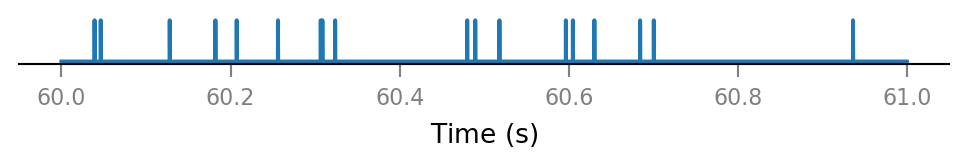

In [19]:
v.spike_train.plot(t_slice, all_spike_trains[0][i_slice]);

All connected presynaptic neurons:

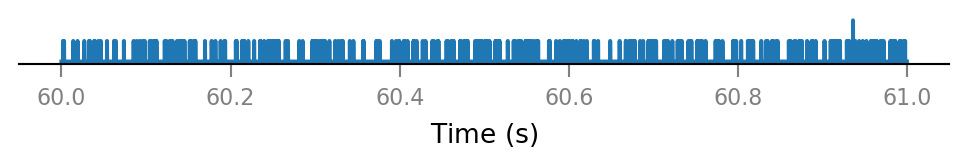

In [20]:
all_incoming_spikes = sum(spike_trains_connected)

v.spike_train.plot(t_slice, all_incoming_spikes[i_slice]);

Note that some time bins contain more than one spike.\
(The simulator handles this, by increasing synaptic conductance by an integer multiple of `Δg_syn` in that timebin).

## Synaptic conductance

See the previous notebook {doc}`/notebooks/2020-07-27__Synaptic_conductances` for some more explanation.

In [22]:
Δg_syn = 0.8 * nS
τ_syn = 7 * ms;

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


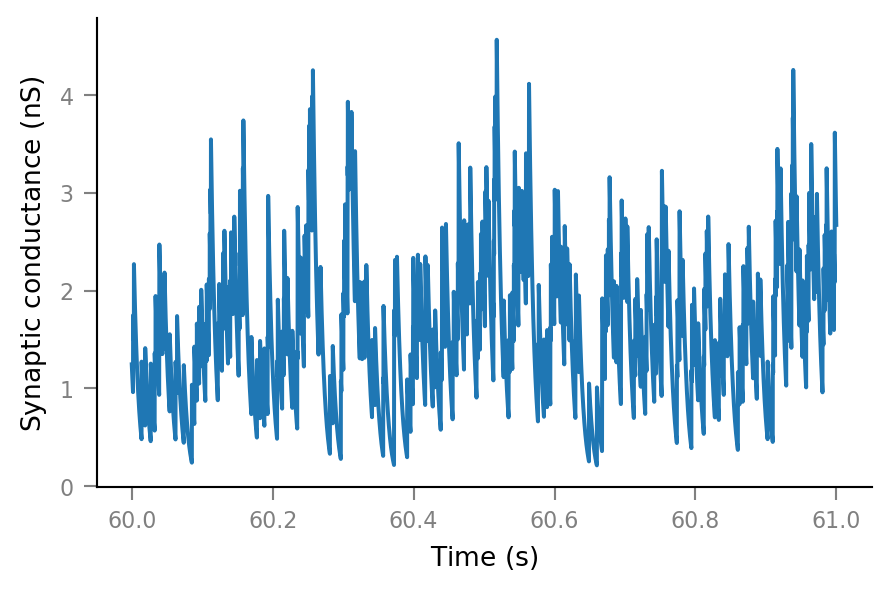

In [23]:
g_syn = v.calc_synaptic_conductance(
    tg, all_incoming_spikes, Δg_syn, τ_syn)

plt.plot(t_slice, g_syn[i_slice]);

## Membrane voltage

In [24]:
params = v.params.cortical_RS
print(params)

IzhikevichParams
----------------
C = 100 pF
k = 0.7 nS/mV
v_r = -60 mV
v_t = -40 mV
v_peak = 35 mV
a = 0.03 1/ms
b = -2 nS
c = -50 mV
d = 100 pA
v_syn = 0 mV


In [25]:
%%time
sim = v.simulate_izh_neuron(tg, params, g_syn)

Wall time: 3.47 s


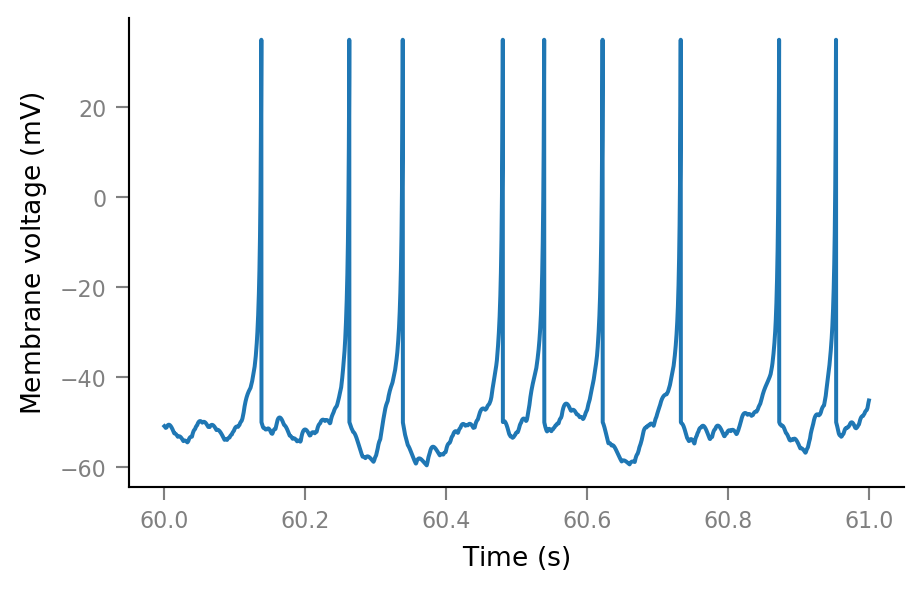

In [26]:
plt.plot(t_slice, sim.V_m[i_slice]);

## Noise

As in {doc}`/notebooks/2020-07-06__Single_neuron_sim`.

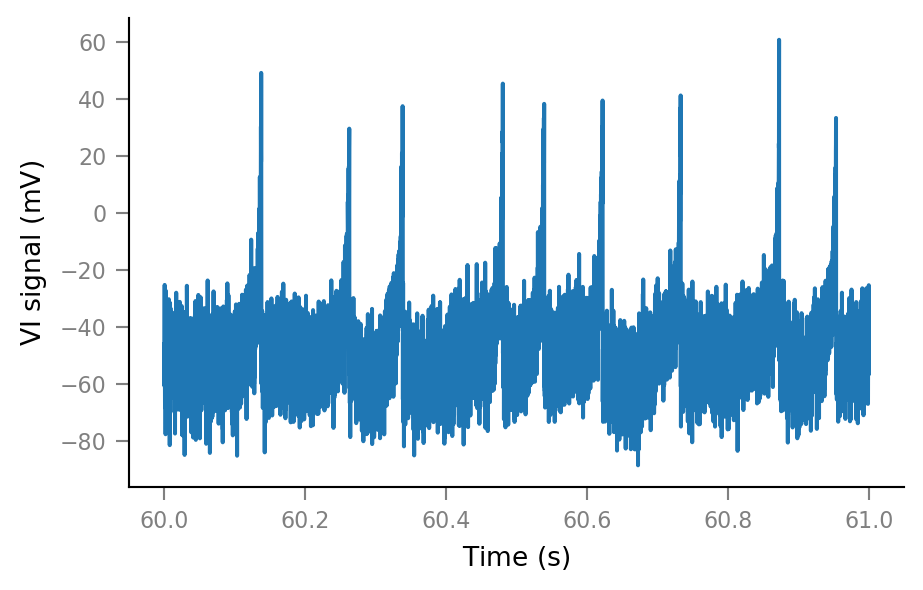

In [27]:
SNR = 10
spike_height = params.v_peak - params.v_r

σ_noise = spike_height / SNR
noise = np.random.randn(tg.N) * σ_noise

Vm_noisy = (sim.V_m + noise).in_units(mV)
Vm_noisy.name = 'VI signal'

plt.plot(t_slice, Vm_noisy[i_slice]);

## Spike-triggered windows

In [28]:
def get_spike_indices(spike_train):
    # `nonzero` returns a tuple (one element for each array dimension).
    (spike_indices,) = np.nonzero(spike_train)  
    return spike_indices

Test with one spike train

In [29]:
spike_train__example = all_spike_trains[0]
spike_indices__example = get_spike_indices(spike_train__example)
num_spikes__example = len(spike_indices__example)
num_spikes__example

12020

Spiking frequency for this presynaptic neuron:

In [30]:
print(Quantity(num_spikes__example / tg.T, Hz))

20.03 Hz


That's to spec.

Extract windows from the VI signal.

In [31]:
window_length = 100 * ms

window_tg = v.TimeGrid(window_length, tg.dt)
window_tg.t.name = "Time after spike"

def make_windows(spike_indices):
    windows = []
    for ix in spike_indices:
        ix_end = ix + window_tg.N
        if ix_end < tg.N:
            windows.append(Vm_noisy[ix:ix_end])
    
    windows = np.stack(windows)
    return Array(windows, V, name=Vm_noisy.name).in_units(mV)

In [32]:
windows__example = make_windows(spike_indices__example)
windows__example.shape

(12019, 1000)

Note that there are generally a few less windows than spikes. This happens when the last few spikes occur too close to the end of the simulation to fit complete windows after them.

An example spike-triggered window:

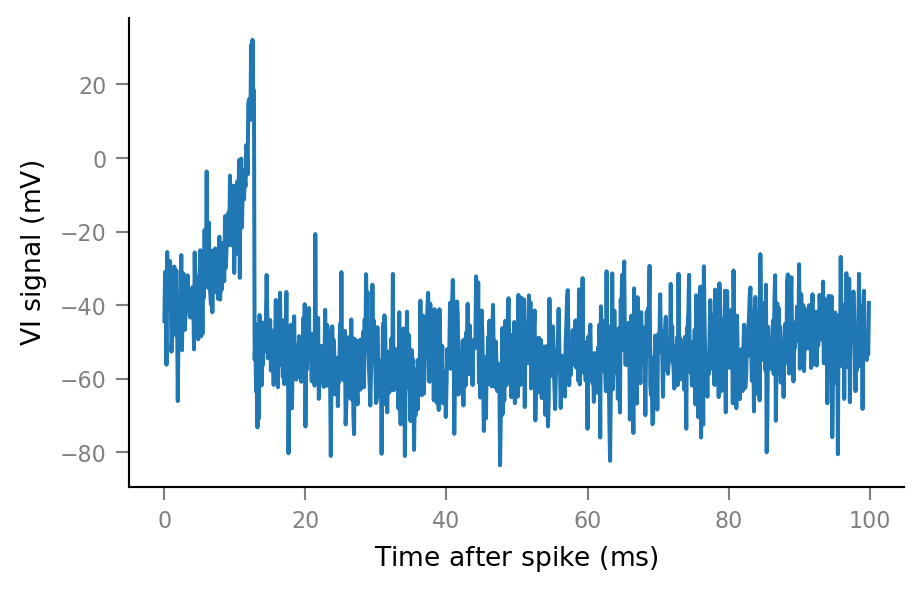

In [33]:
plt.plot(window_tg.t, windows__example[0,:]);

And some more:

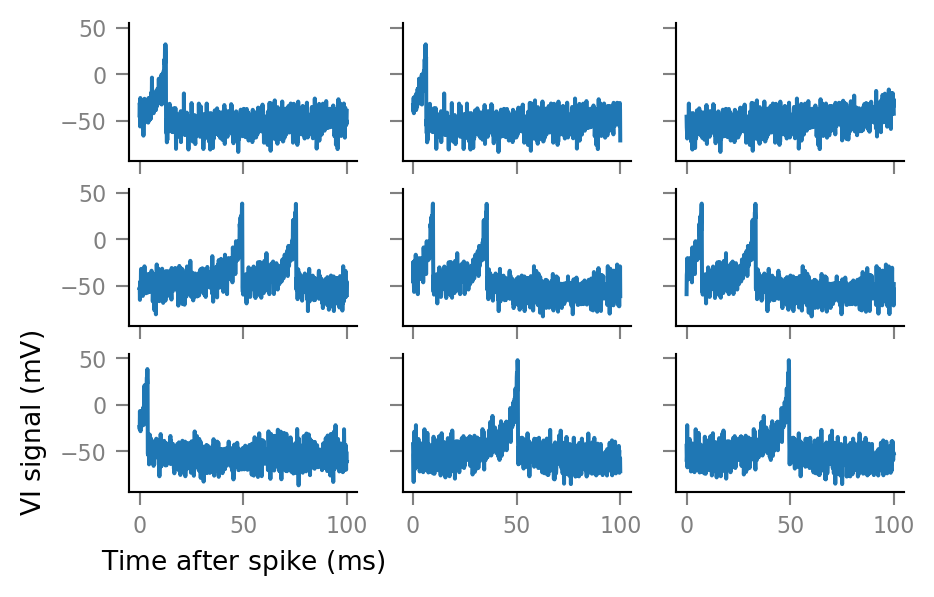

In [34]:
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True)

for row, row_axes in enumerate(axes):
    for col, ax in enumerate(row_axes):
        i = 3*row + col
        ax.plot(window_tg.t, windows__example[i,:])
        if not(row == 2 and col == 0):
            ax.set(xlabel=None, ylabel=None)

Note that the windows overlap considerably. (We see the same postsynaptic spikes here multiple times).

This is to be expected, as the mean time between a presynaptic spike..

In [35]:
print(Quantity(1 / f_spike).in_units(ms))

50 ms


.. is shorter than the window length.

In [36]:
print(window_length)

100 ms


## Average windows

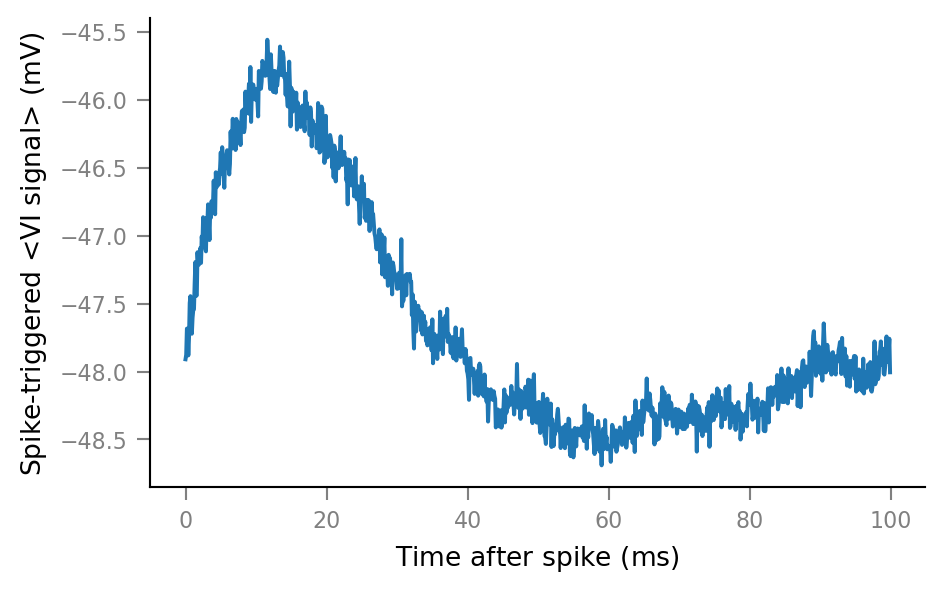

In [39]:
def STA(spike_train):
    spike_indices = get_spike_indices(spike_train)
    windows = make_windows(spike_indices)
    STA = windows.mean(axis=0)
    return Array(STA, V, name="Spike-triggered <VI signal>").in_units(mV)

def plot_STA(spike_train, ax=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(window_tg.t, STA(spike_train), **kwargs)
    
plot_STA(spike_trains_connected[0]);

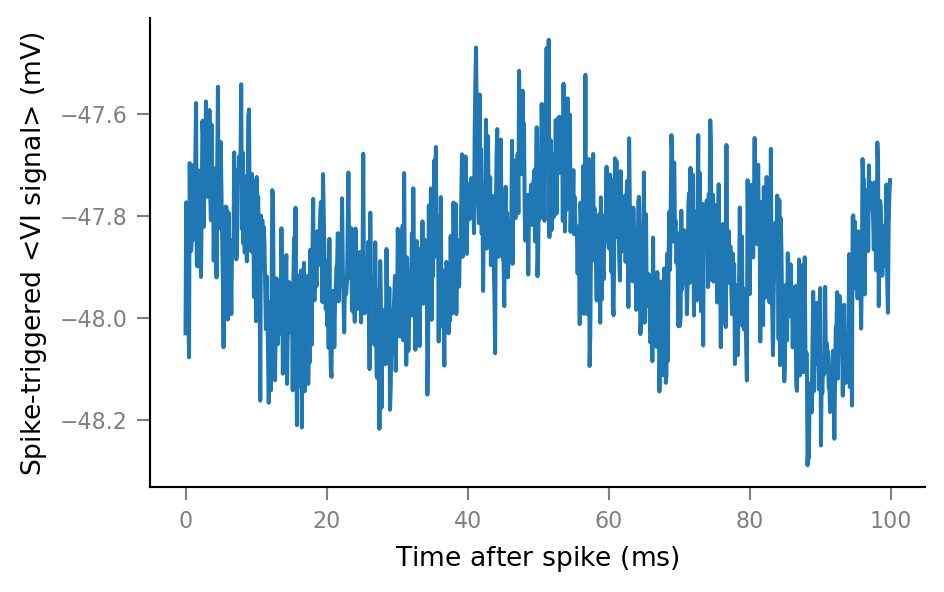

In [40]:
plot_STA(spike_trains_unconnected[0]);

## Plot average windows of all spike trains

In [41]:
%%time

fig, ax = plt.subplots()

for spike_train in spike_trains_connected:
    plot_STA(spike_train, ax, alpha=0.2, color='C0')

for spike_train in spike_trains_unconnected:
    plot_STA(spike_train, ax, alpha=0.2, color='C1')
    
plt.close()

Wall time: 45.3 s


(Again, takes a while. Might possibly be sped up using [LineCollection](https://matplotlib.org/3.1.1/api/collections_api.html#matplotlib.collections.LineCollection)).

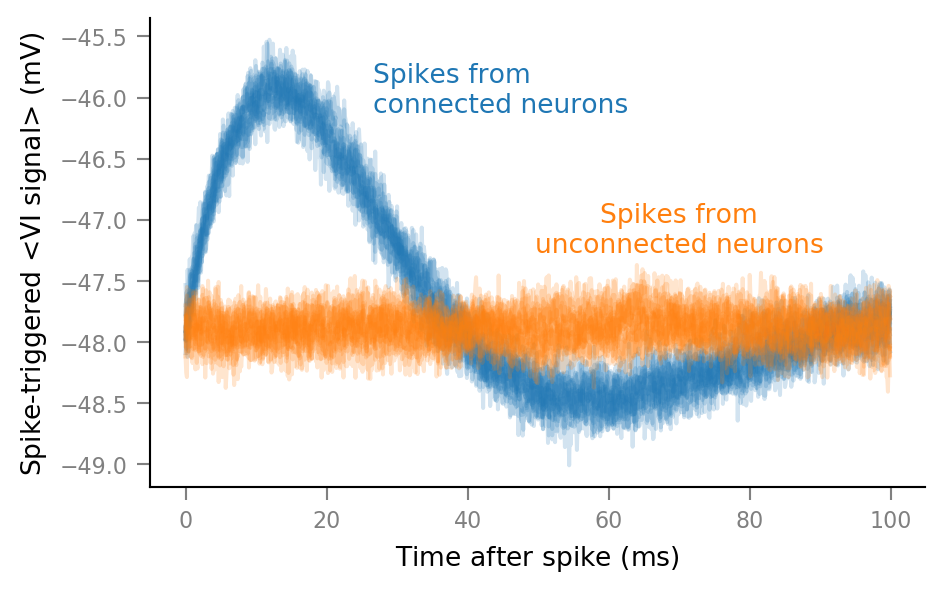

In [42]:
# Clear existing texts, for iterative positioning.
for _ in range(len(ax.texts)):
    ax.texts.pop()

ax.annotate("Spikes from\nconnected neurons",
            xy=(26.55*ms, 0.8), xycoords=('data', 'axes fraction'),
            color="C0", ha="left")

ax.annotate("Spikes from\nunconnected neurons",
            xy=(70*ms, 0.5), xycoords=('data', 'axes fraction'),
            color="C1", ha="center")

fig

[Make this figure re-usable ('transcludable') in other notebooks]:

In [45]:
from myst_nb import glue

glue("first_STAs_fig", fig, display=False)

Next steps: describe influence of `N_in`, `p_connected`, `SNR`, ..